In [2]:
import numpy as np
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import sys

import argparse, os, math, pickle, json

# 1) Load your model
from dual_alm_rnn_models import *
from dual_alm_rnn_exp import DualALMRNNExp
plt.rcParams['pdf.fonttype'] = '42' 


In [10]:
exp = DualALMRNNExp()

# Load configs to get model parameters
with open('dual_alm_rnn_configs.json', 'r') as f:
    configs = json.load(f)

model = getattr(sys.modules[__name__], configs['model_type'])(configs, \
    exp.a, exp.pert_begin, exp.pert_end, noise=True)
# model = TwoHemiRNNTanh_single_readout(configs, exp.a, exp.pert_begin, exp.pert_end)
exp.init_sub_path(configs['train_type'])

checkpoint_file = 'model_epoch_0.pth'
checkpoint_path = os.path.join(configs['models_dir'], configs['model_type'], exp.sub_path, checkpoint_file)
if not os.path.exists(checkpoint_path):
    raise FileNotFoundError(f"Model checkpoint not found at {checkpoint_path}")
print(checkpoint_path)
state_dict = torch.load(checkpoint_path, map_location='cpu', weights_only=True)
model.load_state_dict(state_dict)
# params = {'batch_size': configs['bs'], 'shuffle': True}
# inputs = data.TensorDataset(torch.tensor(sensory_inputs), torch.tensor(trial_type_labels))
# inputs = data.DataLoader(inputs, **params)
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu") # CW Mac update
model = model.to(device)
model.eval()
# Draw the readout trajectory
bias = model.readout_linear.bias.data.cpu().numpy()[0]
readout_weights = model.readout_linear.weight.data.cpu().numpy()
recurrent_weights = model.rnn_cell.w_hh_linear_ll.weight.data.cpu().numpy()
input_weights = model.w_xh_linear_left_alm.weight.data.cpu().numpy()
recurrent_bias = model.rnn_cell.w_hh_linear_ll.bias.data.cpu().numpy()

# print(model.rnn_cell.w_hh_linear_lr.weight.data.cpu().numpy())


Fixed input weights for left and right ALM
dual_alm_rnn_models/TwoHemiRNNTanh_single_readout/train_type_modular_fixed_input/n_neurons_256_random_seed_3/n_epochs_30_n_epochs_across_hemi_0/lr_1.0e-04_bs_256/sigma_input_noise_0.10_sigma_rec_noise_0.10/xs_left_alm_amp_1.00_right_alm_amp_1.00/init_cross_hemi_rel_factor_0.20/model_epoch_0.pth


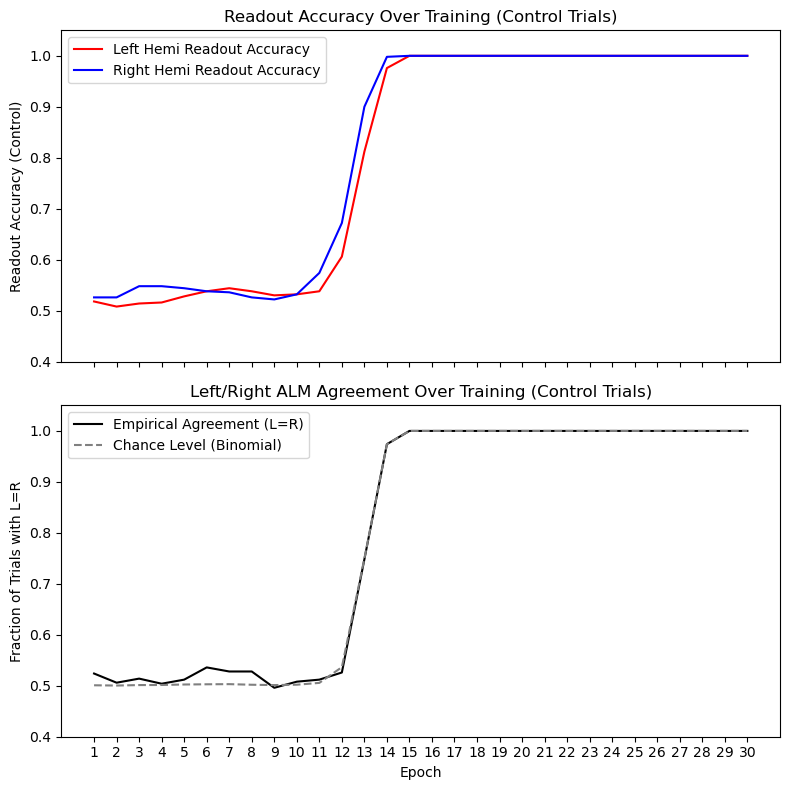

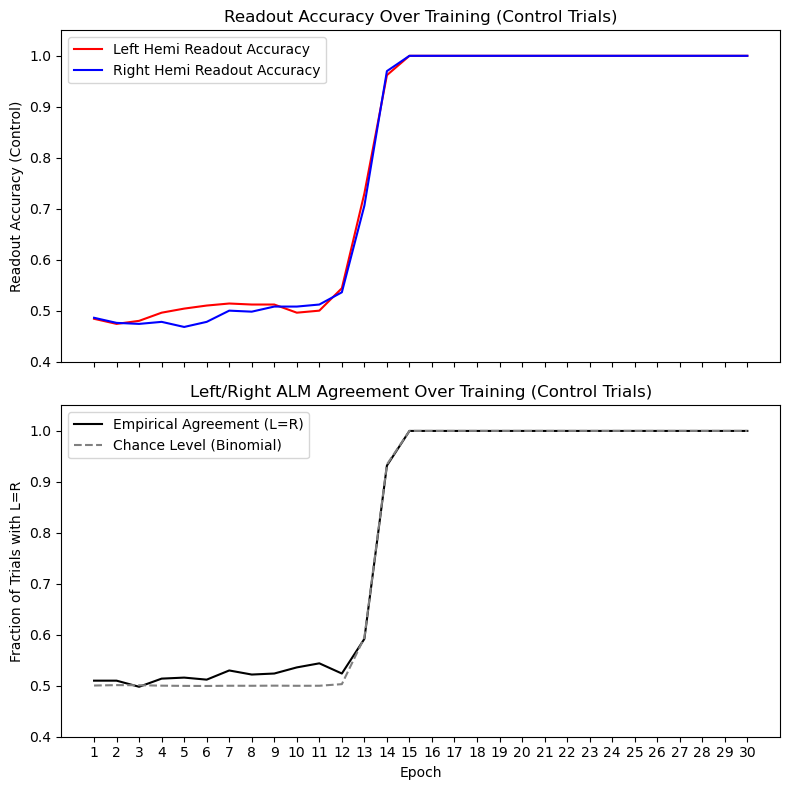

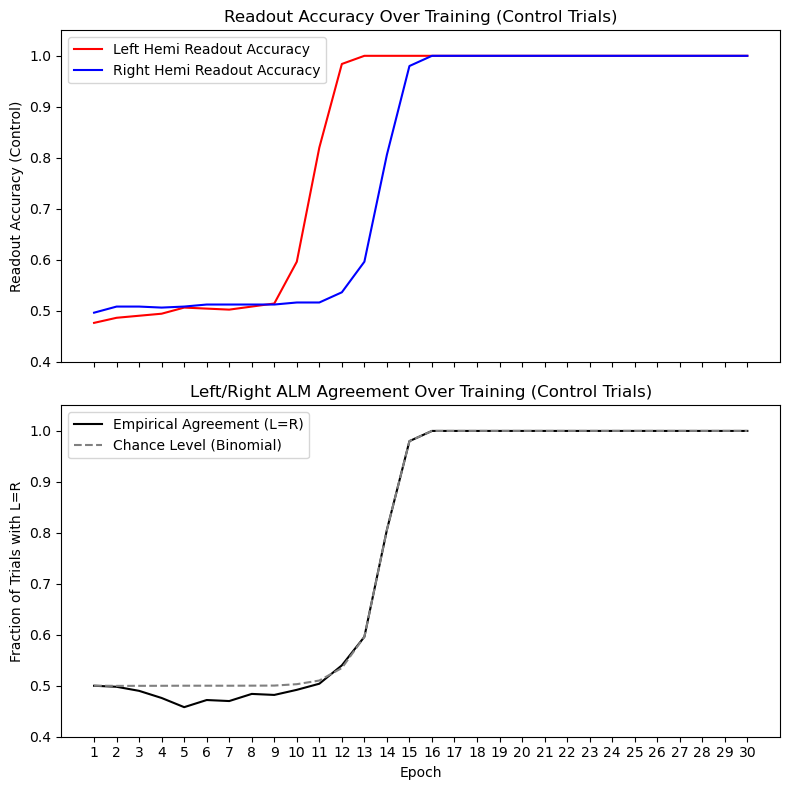

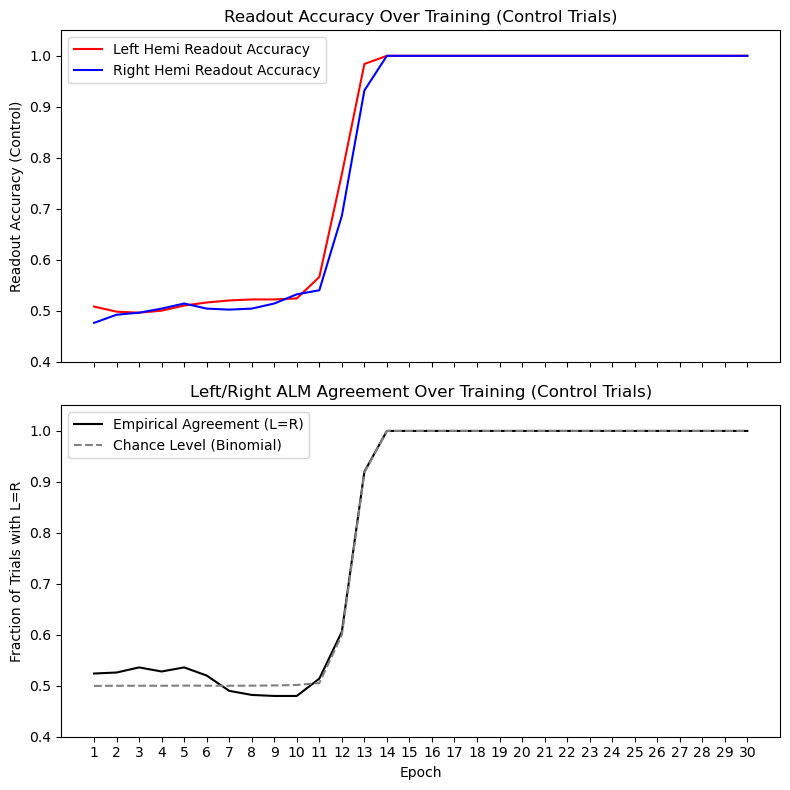

In [ ]:
exp = DualALMRNNExp()


for seed in [0,1,2,3,4,5]:
    results_dict = np.load(
        'dual_alm_rnn_logs/{}/{}/n_neurons_256_random_seed_{}/n_epochs_30_n_epochs_across_hemi_0/lr_1.0e-04_bs_256/sigma_input_noise_0.10_sigma_rec_noise_0.10/xs_left_alm_amp_{:.2f}_right_alm_amp_{:.2f}/init_cross_hemi_rel_factor_0.20/all_val_results_dict.npy'.format(
            exp.configs['model_type'],
            exp.configs['train_type'],
            seed,
            float(exp.configs['xs_left_alm_amp']),
            float(exp.configs['xs_right_alm_amp'])
        ),
        allow_pickle=True
    )
    epochs = np.arange(1, len(results_dict) + 1)
    readout_acc_left = np.array([results_dict[i]['control']['readout_accuracy_left'] for i in range(len(results_dict))])
    readout_acc_right = np.array([results_dict[i]['control']['readout_accuracy_right'] for i in range(len(results_dict))])

    n_trials_agreed = np.array([results_dict[i]['control']['n_trials_agreed'] for i in range(len(results_dict))])
    n_trials = np.array([results_dict[i]['control']['n_trials'] for i in range(len(results_dict))])
    agreement_frac = n_trials_agreed / n_trials

    # Compute chance level: p(agree) = p_L^2 + (1-p_L)^2 if p_L = p_R, but here use both
    chance_agree = readout_acc_left * readout_acc_right + (1 - readout_acc_left) * (1 - readout_acc_right)

    corruption_start_epoch = exp.configs['corruption_start_epoch']

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 8), sharex=True)

    # Top subplot: Readout accuracies
    ax1.plot(epochs, readout_acc_left, color='r', label='Left Hemi Readout Accuracy')
    ax1.plot(epochs, readout_acc_right, color='b', label='Right Hemi Readout Accuracy')
    if exp.configs['train_type'] == 'train_type_modular_corruption':
        ax1.axvline(corruption_start_epoch, color='r', linestyle=':', linewidth=2, label='Corruption Start (Epoch {})'.format(corruption_start_epoch))
    ax1.set_ylabel('Readout Accuracy (Control)')
    ax1.set_title('Readout Accuracy Over Training (Control Trials)')
    ax1.set_xticks(epochs)
    ax1.set_ylim(0.4, 1.05)
    ax1.legend()

    # Bottom subplot: Agreement
    ax2.plot(epochs, agreement_frac, color='k', label='Empirical Agreement (L=R)')
    ax2.plot(epochs, chance_agree, color='gray', linestyle='--', label='Chance Level (Binomial)')
    if exp.configs['train_type'] == 'train_type_modular_corruption':
        ax2.axvline(corruption_start_epoch, color='r', linestyle=':', linewidth=2, label='Corruption Start (Epoch {})'.format(corruption_start_epoch))
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Fraction of Trials with L=R')
    ax2.set_title('Left/Right ALM Agreement Over Training (Control Trials)')
    ax2.set_xticks(epochs)
    ax2.set_ylim(0.4, 1.05)
    ax2.legend()

    plt.tight_layout()
    plt.show()
# if exp.configs['train_type'] == 'train_type_modular_corruption':
#     plt.savefig('figs/LR_readoutacc_and_agreement_learning_{}_L{}_R{}_epoch_{}_noise_{}0_type_{}.pdf'.format(exp.configs['train_type'], 
#                                                                                                             exp.configs['xs_left_alm_amp'], 
#                                                                                                             exp.configs['xs_right_alm_amp'], 
#                                                                                                             exp.configs['corruption_start_epoch'], 
#                                                                                                             exp.configs['corruption_noise'], 
#                                                                                                             exp.configs['corruption_type']))
# elif 'asymmetric_fix' in exp.configs['train_type']:
#     plt.savefig('figs/LR_readoutacc_and_agreement_learning_{}_L{}_R{}_unfix_epoch_{}_type_{}.pdf'.format(exp.configs['train_type'], 
#                                                                                             exp.configs['xs_left_alm_amp'], 
#                                                                                             exp.configs['xs_right_alm_amp'], 
#                                                                                             exp.configs['unfix_epoch'],
#                                                                                             exp.configs['train_type']))
# else:
#     plt.savefig('figs/LR_readoutacc_and_agreement_learning_{}_L{}_R{}_type_{}.pdf'.format(exp.configs['train_type'], 
#                                                                                             exp.configs['xs_left_alm_amp'], 
#                                                                                             exp.configs['xs_right_alm_amp'], 
#                                                                                             exp.configs['train_type']))
# plt.show()